<a href="https://colab.research.google.com/github/rebeccahe1998/E4511-2021-HE/blob/main/DTC_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

In [2]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import requests

# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

In [3]:
! wget https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/DTC_SLC6A3_SMILES.csv

--2021-03-24 22:38:35--  https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/DTC_SLC6A3_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3506249 (3.3M) [text/plain]
Saving to: ‘DTC_SLC6A3_SMILES.csv’

DTC_SLC6A3_SMILES.c 100%[===================>]   3.34M  --.-KB/s    in 0.1s    

2021-03-24 22:38:36 (22.9 MB/s) - ‘DTC_SLC6A3_SMILES.csv’ saved [3506249/3506249]



In [5]:
orig_df = pd.read_csv('DTC_SLC6A3_SMILES.csv', header = 0)
orig_df=orig_df.drop(columns=orig_df.iloc[:,0:2])
orig_df

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES,base_rdkit_smiles
0,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,12213053.0,IC50,=,12.30,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [3H]WIN-35428 from Dopamine Tr...,Mazindol analogues as potential inhibitors of ...,J. Med. Chem.,PUBLICATION,NaN,7.910095,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
1,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,12213053.0,IC50,=,91.00,NM,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of dopamine uptake in HEK cells exp...,Mazindol analogues as potential inhibitors of ...,J. Med. Chem.,PUBLICATION,NaN,7.040959,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
2,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,12213053.0,KI,=,23.10,NM,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [125I]- RTI-55 from Dopamine t...,Mazindol analogues as potential inhibitors of ...,J. Med. Chem.,PUBLICATION,NaN,7.636388,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
3,CHEMBL14144,AAEKULYONKUBOZ-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,14971892.0,KI,=,5.25,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In vitro binding affinity against human dopami...,"Synthesis, radiosynthesis, and biological eval...",J. Med. Chem.,PUBLICATION,NaN,8.279841,CN1C2CCC1C(C(C2)C3=CC=C(C=C3)Cl)C(=O)OC4=CC=CC=C4,CN1C2CCC1C(C(=O)Oc1ccccc1)C(c1ccc(Cl)cc1)C2
4,CHEMBL3323101,AAHLCKVWZXFMPB-UHFFFAOYSA-N,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,25050161.0,IC50,=,4.50,NM,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Displacement of [3H]WIN 35,428 from human DAT ...",NaN,ACS Med. Chem. Lett.,PUBLICATION,NaN,8.346787,CN1CC(C2=CC=CC=C2C1)C3=CC4=C(C=C3)NC=C4,CN1Cc2ccccc2C(c2ccc3[nH]ccc3c2)C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,CHEMBL3819201,NaN,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,27325446.0,IC50,>,1000.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human DAT expressed in CHO cells...,"Design, synthesis, and biological evaluation o...",Bioorg. Med. Chem.,PUBLICATION,NaN,6.000000,C1CO[C@H]([C@@H](CN1)CN2C=CC=CC2=O)C3=CC(=C(C=...,O=c1ccccn1C[C@@H]1CNCCO[C@H]1c1ccc(Cl)c(F)c1
7180,CHEMBL3819217,NaN,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,27325446.0,IC50,>,1000.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human DAT expressed in CHO cells...,"Design, synthesis, and biological evaluation o...",Bioorg. Med. Chem.,PUBLICATION,NaN,6.000000,C1CO[C@H]([C@@H](CN1)CN2C(=O)C=CC=C2C3=NOC(=O)...,O=c1[nH]c(-c2cccc(=O)n2C[C@@H]2CNCCO[C@H]2c2cc...
7181,CHEMBL3819243,NaN,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,27325446.0,IC50,=,240.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human DAT expressed in CHO cells...,"Design, synthesis, and biological evaluation o...",Bioorg. Med. Chem.,PUBLICATION,NaN,6.619789,C1CO[C@H]([C@@H](CN1)CN2C(=O)C=CC=N2)C3=CC(=C(...,O=c1cccnn1C[C@@H]1CNCCO[C@H]1c1ccc(Cl)c(F)c1
7182,CHEMBL3819441,NaN,NaN,NaN,Q01959,DOPAMINE TRANSPORTER,SLC6A3,NaN,NaN,27325446.0,IC50,>,1000.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [6]:
orig_df.columns

Index(['compound_id', 'standard_inchi_key', 'compound_name', 'synonym',
       'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant',
       'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'activity_comment',
       'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype',
       'inhibitor_type', 'detection_tech', 'assay_cell_line',
       'compound_concentration_value', 'compound_concentration_value_unit',
       'substrate_type', 'substrate_relation', 'substrate_value',
       'substrate_units', 'assay_description', 'title', 'journal', 'doc_type',
       'annotation_comments', 'pDTC_Value', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

In [10]:
df = orig_df[['compound_id','standard_inchi_key','standard_type','standard_relation',
       'standard_value', 'standard_units','pDTC_Value', 'SMILES', 'base_rdkit_smiles']]
df

,compound_id,standard_inchi_key,standard_type,standard_relation,standard_value,standard_units,pDTC_Value,SMILES,base_rdkit_smiles
0,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,IC50,=,12.30,NM,7.910095,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
1,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,IC50,=,91.00,NM,7.040959,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
2,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,KI,=,23.10,NM,7.636388,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
3,CHEMBL14144,AAEKULYONKUBOZ-UHFFFAOYSA-N,KI,=,5.25,NM,8.279841,CN1C2CCC1C(C(C2)C3=CC=C(C=C3)Cl)C(=O)OC4=CC=CC=C4,CN1C2CCC1C(C(=O)Oc1ccccc1)C(c1ccc(Cl)cc1)C2
4,CHEMBL3323101,AAHLCKVWZXFMPB-UHFFFAOYSA-N,IC50,=,4.50,NM,8.346787,CN1CC(C2=CC=CC=C2C1)C3=CC4=C(C=C3)NC=C4,CN1Cc2ccccc2C(c2ccc3[nH]ccc3c2)C1
...,...,...,...,...,...,...,...,...,...
7179,CHEMBL3819201,NaN,IC50,>,1000.00,NM,6.000000,C1CO[C@H]([C@@H](CN1)CN2C=CC=CC2=O)C3=CC(=C(C=...,O=c1ccccn1C[C@@H]1CNCCO[C@H]1c1ccc(Cl)c(F)c1
7180,CHEMBL3819217,NaN,IC50,>,1000.00,NM,6.000000,C1CO[C@H]([C@@H](CN1)CN2C(=O)C=CC=C2C3=NOC(=O)...,O=c1[nH]c(-c2cccc(=O)n2C[C@@H]2CNCCO[C@H]2c2cc...
7181,CHEMBL3819243,NaN,IC50,=,240.00,NM,6.619789,C1CO[C@H]([C@@H](CN1)CN2C(=O)C=CC=N2)C3=CC(=C(...,O=c1cccnn1C[C@@H]1CNCCO[C@H]1c1ccc(Cl)c(F)c1
7182,CHEMBL3819441,NaN,IC50,>,1000.00,NM,6.000000,C1CO[C@H]([C@@H](CN1)CN2C=CC=C(C2=O)C(=O)O)C3=...,O=C(O)c1cccn(C[C@@H]2CNCCO[C@H]2c2ccc(Cl)c(F)c...


In [14]:
df.standard_type.value_counts()

IC50                    2991
KI                      2927
INHIBITION               851
ACTIVITY                 118
RATIO                     76
PKD                       56
LOG 1/C                   50
Ki                        49
KD                        20
EC50                      10
Inhibition                 7
Activity                   4
DISPLACEMENT               4
RATIO KI                   4
IC5                        4
PKI                        3
EFFICACY                   2
DISCRIMINATION RATIO       1
INH                        1
SELECTIVITY RATIO          1
AFFINITY                   1
Name: standard_type, dtype: int64

In [13]:
print(sum(df['pDTC_Value'].isna()) )
print(len(df) - sum(df['pDTC_Value'].isna()))

len(orig_df)


1838
5346


7184

In [ ]:
# filter out to have df of standard type IC/EC50, non empty standard value, non empoty inchi key,
# non-empty compound id, standard units = 'NM'

In [15]:
orig_df.gene_names.value_counts()

SLC6A3    7184
Name: gene_names, dtype: int64

In [49]:
dset_df = df[~(df.standard_inchi_key.isna())  &
            (df.standard_units == 'NM') &
            ~df.standard_value.isna() &
            ~df.compound_id.isna() &
             (df.standard_relation == '=') &
             ~df.standard_relation.isna()]

In [53]:
dset_df = dset_df.loc[(df.standard_type == 'IC50') | (df.standard_type == 'EC50')]
dset_df

,compound_id,standard_inchi_key,standard_type,standard_relation,standard_value,standard_units,pDTC_Value,SMILES,base_rdkit_smiles
0,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,IC50,=,12.3,NM,7.910095,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
1,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,IC50,=,91.0,NM,7.040959,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
4,CHEMBL3323101,AAHLCKVWZXFMPB-UHFFFAOYSA-N,IC50,=,4.5,NM,8.346787,CN1CC(C2=CC=CC=C2C1)C3=CC4=C(C=C3)NC=C4,CN1Cc2ccccc2C(c2ccc3[nH]ccc3c2)C1
9,CHEMBL3334773,AAXDLPLNFKHHPR-UHFFFAOYSA-N,IC50,=,291.4,NM,6.535510,C1CCN(C1)C(CCN2CCC(=CC2)CC3=CC=CC=C3)C4=CC(=C(...,Clc1ccc(C(CCN2CC=C(Cc3ccccc3)CC2)N2CCCC2)cc1Cl
18,CHEMBL565844,ABPSWEJOHYDZDP-UHFFFAOYSA-N,IC50,=,650.0,NM,6.187087,CC1=C(C=C(C=C1)C(=O)C(C)NC(C)(C)C)Cl,Cc1ccc(C(=O)C(C)NC(C)(C)C)cc1Cl
...,...,...,...,...,...,...,...,...,...
7119,CHEMBL64894,ZXJXZNDDNMQXFV-UHFFFAOYSA-M,IC50,=,4069.0,NM,5.390512,CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=...,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccc(N(C)...
7130,CHEMBL218849,ZYPXTTXHMBCKFT-UHFFFAOYSA-N,IC50,=,8.2,NM,8.086186,CCCCC(C1CCCCN1)C2=CC=C(C=C2)Cl,CCCCC(c1ccc(Cl)cc1)C1CCCCN1
7131,CHEMBL218849,ZYPXTTXHMBCKFT-UHFFFAOYSA-N,IC50,=,170.0,NM,6.769551,CCCCC(C1CCCCN1)C2=CC=C(C=C2)Cl,CCCCC(c1ccc(Cl)cc1)C1CCCCN1
7144,CHEMBL1683875,ZZRHLICOWQQNJL-UHFFFAOYSA-N,IC50,=,1.0,NM,9.000000,CCN(C)CC1(CCCCC1)C2=CC(=C(C=C2)Cl)Cl,CCN(C)CC1(c2ccc(Cl)c(Cl)c2)CCCCC1


In [ ]:
for col in dset_df.columns:
    print(dset_df[col].value_counts())

In [58]:
dset_df.dtypes

compound_id            object
standard_inchi_key     object
standard_type          object
standard_relation      object
standard_value        float64
standard_units         object
pDTC_Value            float64
SMILES                 object
base_rdkit_smiles      object
dtype: object

In [60]:
sum(dset_df.base_rdkit_smiles.isna())

0

In [64]:
dset_df = dset_df.rename(columns={"pDTC_Value": "pXC50"})
dset_df.columns

Index(['compound_id', 'standard_inchi_key', 'standard_type',
       'standard_relation', 'standard_value', 'standard_units', 'pXC50',
       'SMILES', 'base_rdkit_smiles'],
      dtype='object')

In [65]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [68]:
dset_df.to_csv('drive/MyDrive/DTC_DROP.csv')

Canonicalizing 1406 molecules...
Done
Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


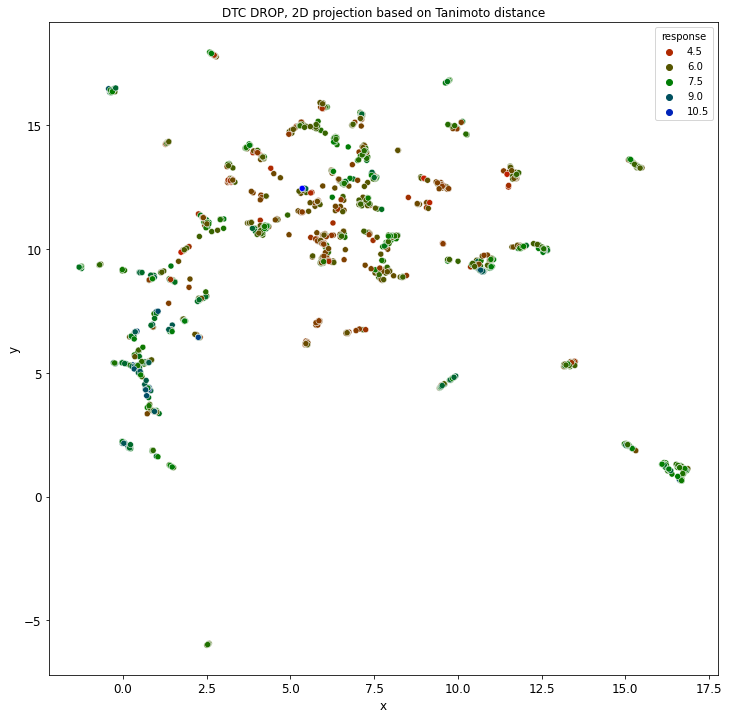

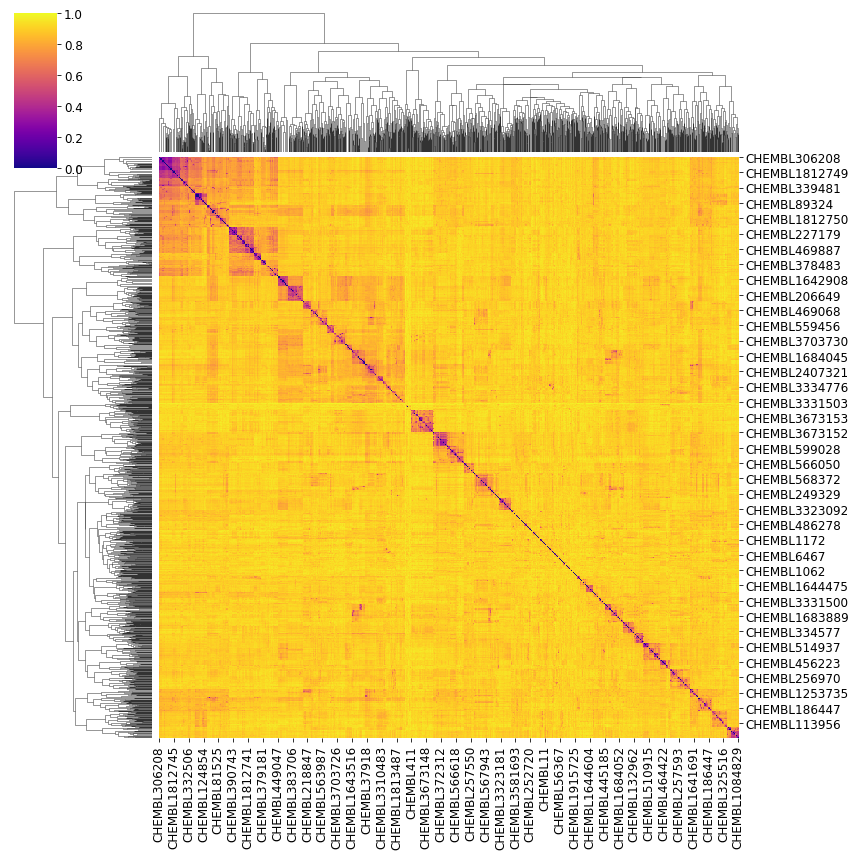

In [74]:

dp.diversity_plots(dset_key = 'drive/MyDrive/DTC_DROP.csv',
                   datastore = False,
                   response_col = 'pXC50', smiles_col='base_rdkit_smiles',
                   max_for_mcs = 100)

In [76]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = dset_df['base_rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

print(len(dist_sample))
print(len(smiles_lst1))

1740
1740


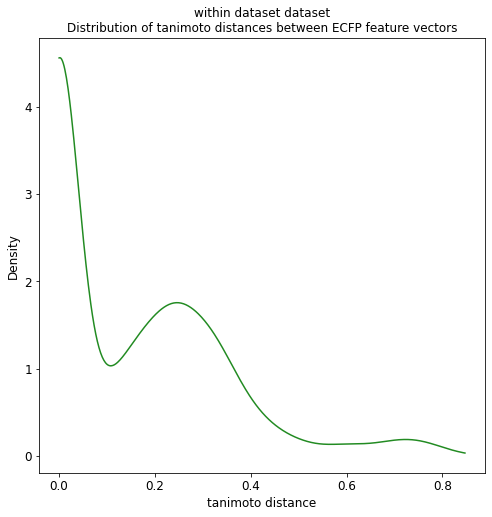

In [77]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [78]:
dset_df

,compound_id,standard_inchi_key,standard_type,standard_relation,standard_value,standard_units,pXC50,SMILES,base_rdkit_smiles
0,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,IC50,=,12.3,NM,7.910095,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
1,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,IC50,=,91.0,NM,7.040959,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F,OC1(c2ccc(Cl)cc2)c2cccc(F)c2C2=NCCN21
4,CHEMBL3323101,AAHLCKVWZXFMPB-UHFFFAOYSA-N,IC50,=,4.5,NM,8.346787,CN1CC(C2=CC=CC=C2C1)C3=CC4=C(C=C3)NC=C4,CN1Cc2ccccc2C(c2ccc3[nH]ccc3c2)C1
9,CHEMBL3334773,AAXDLPLNFKHHPR-UHFFFAOYSA-N,IC50,=,291.4,NM,6.535510,C1CCN(C1)C(CCN2CCC(=CC2)CC3=CC=CC=C3)C4=CC(=C(...,Clc1ccc(C(CCN2CC=C(Cc3ccccc3)CC2)N2CCCC2)cc1Cl
18,CHEMBL565844,ABPSWEJOHYDZDP-UHFFFAOYSA-N,IC50,=,650.0,NM,6.187087,CC1=C(C=C(C=C1)C(=O)C(C)NC(C)(C)C)Cl,Cc1ccc(C(=O)C(C)NC(C)(C)C)cc1Cl
...,...,...,...,...,...,...,...,...,...
7119,CHEMBL64894,ZXJXZNDDNMQXFV-UHFFFAOYSA-M,IC50,=,4069.0,NM,5.390512,CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=...,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccc(N(C)...
7130,CHEMBL218849,ZYPXTTXHMBCKFT-UHFFFAOYSA-N,IC50,=,8.2,NM,8.086186,CCCCC(C1CCCCN1)C2=CC=C(C=C2)Cl,CCCCC(c1ccc(Cl)cc1)C1CCCCN1
7131,CHEMBL218849,ZYPXTTXHMBCKFT-UHFFFAOYSA-N,IC50,=,170.0,NM,6.769551,CCCCC(C1CCCCN1)C2=CC=C(C=C2)Cl,CCCCC(c1ccc(Cl)cc1)C1CCCCN1
7144,CHEMBL1683875,ZZRHLICOWQQNJL-UHFFFAOYSA-N,IC50,=,1.0,NM,9.000000,CCN(C)CC1(CCCCC1)C2=CC(=C(C=C2)Cl)Cl,CCN(C)CC1(c2ccc(Cl)c(Cl)c2)CCCCC1


In [80]:

import os

# From our dataframe, we are working with the PIC50 column 
data=dset_df

column = 'pXC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'standard_inchi_key'

# smiles_col: SMILES column
smiles_col = 'base_rdkit_smiles'

# Here we are creating a new dataframe, called check_df
check_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (1711, 13)
List of 'bad' duplicates removed
               standard_inchi_key     pXC50  ...   Perc_Var  VALUE_NUM_std
109   BMRJUXFHOOHDBF-UHFFFAOYSA-N  7.657577  ...  13.601383       1.296599
110   BMRJUXFHOOHDBF-UHFFFAOYSA-N  5.823909  ...  13.601383       1.296599
117   BRQZSYKMAXVFLP-UHFFFAOYSA-N  8.552842  ...   9.593094       1.058768
118   BRQZSYKMAXVFLP-UHFFFAOYSA-N  7.055517  ...   9.593094       1.058768
170   CJUVIUZOUUBMJB-UHFFFAOYSA-N  7.638272  ...  15.809356       1.474622
171   CJUVIUZOUUBMJB-UHFFFAOYSA-N  5.552842  ...  15.809356       1.474622
221   DHXSMGUKIICGAC-TVQRCGJNSA-N  5.476254  ...  14.652248       1.329568
222   DHXSMGUKIICGAC-TVQRCGJNSA-N  7.356547  ...  14.652248       1.329568
230   DJLLHNLJLSEKHJ-UHFFFAOYSA-N  7.958607  ...  17.667835       1.689965
231   DJLLHNLJLSEKHJ-UHFFFAOYSA-N  5.568636  ...  17.667835       1.689965
590   JUKMAYKVHWKRKY-UHFFFAOYSA-N  7.638272  ...  11.222000       1.089908
591  

In [85]:

old_compound_id='base_rdkit_smiles'
new_compound_id='base_rdkit_smiles'

# Takes all the compounds that aren't part of the curated data frame and prints them
reject=data[~data[old_compound_id].isin(check_df[new_compound_id])]
reject

,compound_id,standard_inchi_key,standard_type,standard_relation,standard_value,standard_units,pXC50,SMILES,base_rdkit_smiles
470,CHEMBL219224,BMRJUXFHOOHDBF-UHFFFAOYSA-N,IC50,=,22.0,NM,7.657577,CC(C1CCCCN1)C2=CC=C(C=C2)Cl,CC(c1ccc(Cl)cc1)C1CCCCN1
471,CHEMBL219224,BMRJUXFHOOHDBF-UHFFFAOYSA-N,IC50,=,1500.0,NM,5.823909,CC(C1CCCCN1)C2=CC=C(C=C2)Cl,CC(c1ccc(Cl)cc1)C1CCCCN1
510,CHEMBL219335,BRQZSYKMAXVFLP-UHFFFAOYSA-N,IC50,=,2.8,NM,8.552842,CC(C)CC(C1CCCCN1)C2=CC(=CC=C2)Cl,CC(C)CC(c1cccc(Cl)c1)C1CCCCN1
511,CHEMBL219335,BRQZSYKMAXVFLP-UHFFFAOYSA-N,IC50,=,88.0,NM,7.055517,CC(C)CC(C1CCCCN1)C2=CC(=CC=C2)Cl,CC(C)CC(c1cccc(Cl)c1)C1CCCCN1
716,CHEMBL376852,CJUVIUZOUUBMJB-UHFFFAOYSA-N,IC50,=,23.0,NM,7.638272,CCC(C1CCCCN1)C2=CC=C(C=C2)Cl,CCC(c1ccc(Cl)cc1)C1CCCCN1
717,CHEMBL376852,CJUVIUZOUUBMJB-UHFFFAOYSA-N,IC50,=,2800.0,NM,5.552842,CCC(C1CCCCN1)C2=CC=C(C=C2)Cl,CCC(c1ccc(Cl)cc1)C1CCCCN1
966,CHEMBL1173276,DHXSMGUKIICGAC-TVQRCGJNSA-N,IC50,=,3340.0,NM,5.476254,C[C@H]1[C@@](OCC(N1)(C)C)(C2=CC(=CC=C2)Br)O,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cccc(Br)c1
967,CHEMBL1173276,DHXSMGUKIICGAC-TVQRCGJNSA-N,IC50,=,44.0,NM,7.356547,C[C@H]1[C@@](OCC(N1)(C)C)(C2=CC(=CC=C2)Br)O,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cccc(Br)c1
991,CHEMBL219116,DJLLHNLJLSEKHJ-UHFFFAOYSA-N,IC50,=,11.0,NM,7.958607,COC(=O)C(C1CCCCN1)C2=CC=C(C=C2)Cl,COC(=O)C(c1ccc(Cl)cc1)C1CCCCN1
992,CHEMBL219116,DJLLHNLJLSEKHJ-UHFFFAOYSA-N,IC50,=,2700.0,NM,5.568636,COC(=O)C(C1CCCCN1)C2=CC=C(C=C2)Cl,COC(=O)C(c1ccc(Cl)cc1)C1CCCCN1


In [86]:
column='pXC50'; #'standard_value'
list_bad_duplicates='Yes'

# Actually compiles all the data with the specifies column and tells what columns to include 
# (inchi_key, smiles, and relation)
temp_df=curate_data.aggregate_assay_data(data, 
                                         value_col=column, 
                                         output_value_col=None,
                                         label_actives=True,
                                         active_thresh=6,
                                         id_col='standard_inchi_key', 
                                         smiles_col='base_rdkit_smiles', 
                                         relation_col='standard_relation')

#Removes all duplicates from the data frame and puts it in the final, curated dataframe
curated_df = temp_df[~temp_df.isin([np.inf]).any(1)]

0 entries in input table are missing SMILES strings
1406 unique SMILES strings are reduced to 1406 unique base SMILES strings


In [88]:
curated_df.to_csv('drive/MyDrive/DTC_Curated.csv')

In [89]:

# Prints number of unique resjected compound names/rows
print("Number of discarded compounds",reject[compound_id].nunique())

Number of discarded compounds 15


(0.0, 12.0)

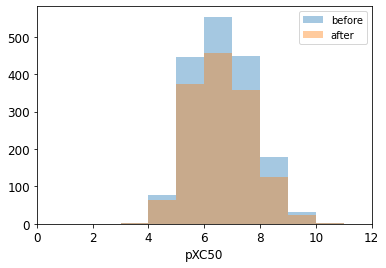

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()


before=dset_df["pXC50"]

# Our after variable is comprised of our curated_df dataframe 
# Our curated_df was configured earlier to discard any out of range values
after=curated_df["pXC50"]

# plots the values of the response value column of both the before and after dataframes from above
# sns.distplot is a Seaborn distplot, which allows you to show a histogram with a line on it
# A distplot plots a univariate distribution of observations 
# Below, we are separating our data set into a before section and an after section 
# To break down the sns.distplot functions: 
# bins=range(0, 12, 1) is used to bin our range of values, meaning to divide the entire range of values into a series of intervals
# ax=ax 
# kde is a kernel density estimate plot that represents the data using a continuous probability density curve
# kde=False will remove the density line on the histogram
# The label= function is used to label different sections of our plot 
sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')

#configures plot by adding a legend and setting the x axis limits for readability
# plt.legend() adds the legend to the plot
plt.legend()

# ax.set_xlim is setting the x-axis limits of the graph, setting it to be from (0,12)
ax.set_xlim([0, 12])